## Modeling Vehicle Fuel Consumption Based on Car Specifications  
### Linear Regression Built from First Principles


In [65]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import boxcox

import sys
sys.path.append('..')

from models.linear_models.linear_regression import LinearRegression

In [66]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'car.csv'))
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino



## Let's start with missing values and dropping values that dont reach a certain correlation threshold with mpg


In [67]:

    
df.drop(["car name"],axis=1, inplace=True)
df.replace("?", np.nan,inplace=True)
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')


In [68]:

missing = df.isna().sum()

for col,num in missing.items():
    print(col, num)


mpg 0
cylinders 0
displacement 0
horsepower 6
weight 0
acceleration 0
model year 0
origin 0


In [69]:
def feature_selection(df,target='mpg',target_threshold=0.5, inter_feat_thresh=0.85):
    # Correlation with target
    corr_matrix = df.corr()
    corr_target = corr_matrix[target].abs()
    strong_features = corr_target[corr_target >= target_threshold].index
    
    df_filtered = df[strong_features]
    
    # Remove multicollinear predictors
    predictors = df_filtered.drop(columns=[target])
    corr_predictors = predictors.corr().abs()
    
    # Consider only upper triangle
    upper_triangle = corr_predictors.where(
        np.triu(np.ones(corr_predictors.shape), k=1).astype(bool)
    )
    
    to_drop = [col for col in upper_triangle.columns 
               if any(upper_triangle[col]>inter_feat_thresh)]
    
    df_final = df_filtered.drop(columns=to_drop)
    
    return df_final

In [70]:
df_clean = feature_selection(df, target='mpg', target_threshold=0.3, inter_feat_thresh=0.9)
print("Selected features:", df_clean.columns.tolist())


Selected features: ['mpg', 'cylinders', 'horsepower', 'acceleration', 'model year', 'origin']


c:\Users\takun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


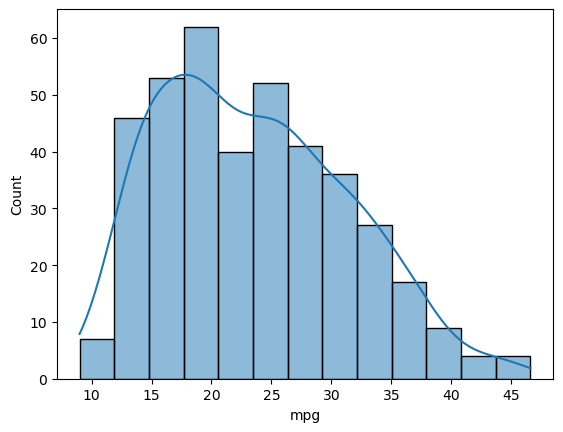

In [71]:
mpg_skew = sns.histplot(df_clean["mpg"],kde=True)
plt.show()

c:\Users\takun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


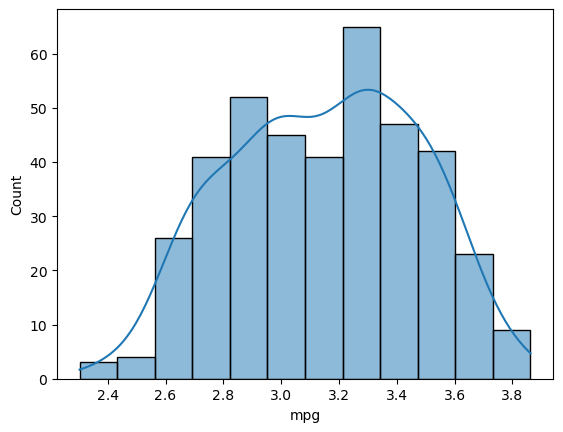

In [72]:
log_mpg = sns.histplot(np.log1p(df_clean["mpg"]),kde=True)
plt.show()

c:\Users\takun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Optimal lambda: 0.19735475361200427


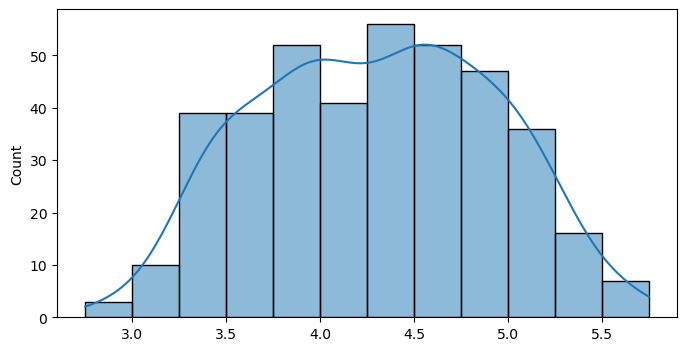

In [73]:
mpg_transformed, lambda_val = boxcox(df_clean['mpg'])
print("Optimal lambda:", lambda_val)

plt.figure(figsize=(8,4))
sns.histplot(mpg_transformed, kde=True)
plt.show()

In [74]:
df_clean['mpg_transformed'] = mpg_transformed

In [75]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def preprocessing_pipeline(df):
    # Get numeric and categorical columns from the dataframe passed in
    numeric_cols = df.select_dtypes(include=np.number).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    numeric_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy="most_frequent")),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Add this
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    return preprocessor

In [76]:
from sklearn.model_selection import train_test_split

X = df_clean.drop('mpg_transformed', axis=1)
y = df_clean['mpg_transformed']

# Create and fit the preprocessor
preprocessor = preprocessing_pipeline(X)
X_transformed = preprocessor.fit_transform(X)



print("X_transformed shape:", X_transformed.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

X_transformed shape: (398, 6)
y shape: (398,)
Iteration 100/1000 - Loss: 0.3619
Iteration 200/1000 - Loss: 0.0186
Iteration 300/1000 - Loss: 0.0081
Iteration 400/1000 - Loss: 0.0060
Iteration 500/1000 - Loss: 0.0051
Iteration 600/1000 - Loss: 0.0046
Iteration 700/1000 - Loss: 0.0044
Iteration 800/1000 - Loss: 0.0042
Iteration 900/1000 - Loss: 0.0042
Iteration 1000/1000 - Loss: 0.0041


In [77]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)

mae = mean_absolute_error(y,y_pred)
rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)

print("Mean Absolute Error: ",mae)
print("Root Mean Squared Error: ", rmse)
print("r^2: ",r2)

ValueError: Found input variables with inconsistent numbers of samples: [398, 80]